In [2]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from torchvision import datasets
from torchvision.transforms import v2

In [32]:
print(torchvision.__version__)

NameError: name 'torchvision' is not defined

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

## CIFAR-10 Dataset

In [4]:
train_transform = v2.Compose([v2.Resize((32,32)),
                              v2.RandomHorizontalFlip(p=0.3),
                              v2.RandomRotation(10),
                              v2.RandomAffine(degrees=20, scale=(0.8, 1.2)),
                              v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                              v2.ToTensor(),
                              v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #because there are coloured imagers


transform = v2.Compose([v2.Resize((32,32)),
                        v2.ToTensor(),
                        v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #because there are coloured imagers

training_dataset = datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

C:\Users\CK868LZ\AppData\Local\anaconda3\envs\vision\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [5]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, 
                                              batch_size=100, shuffle=True) #we do this because we can't pass 60000 images at once

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=100, shuffle=False)

In [6]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy() #shape of image is (3,32,32) --> (colour, width, height)
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) #we actually multiply with the mean and add the std to denormalize the image
    image = image.clip(0,1) #to ensure that values are between 0 and 1
    return image 

In [7]:
classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

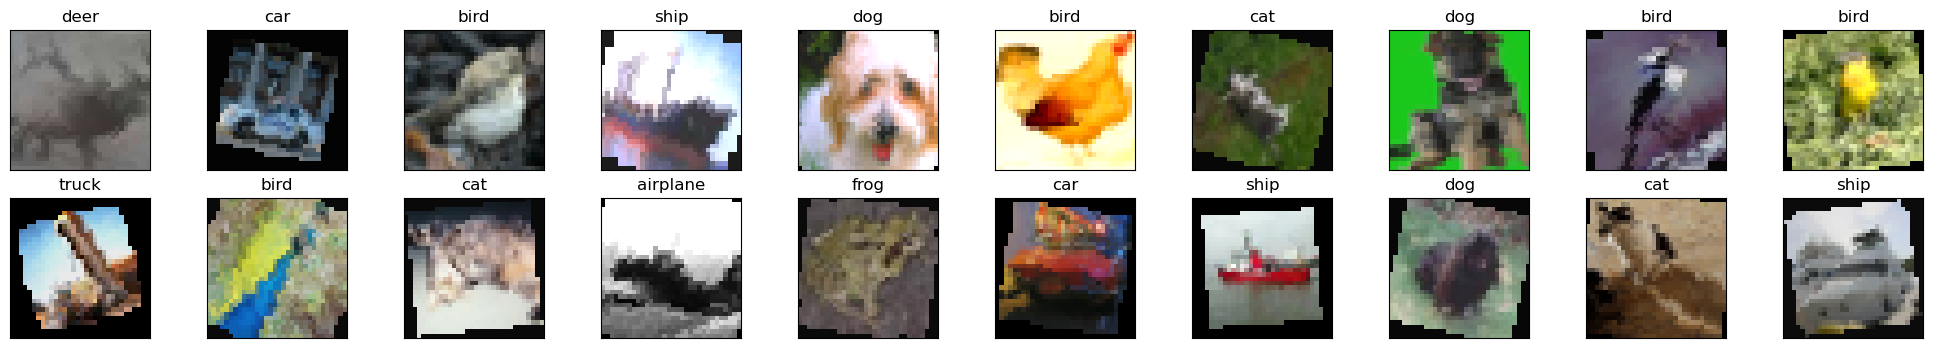

In [8]:
data_iter = iter(training_loader)
images, labels = next(data_iter)
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

## Model Initialization

In [25]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 128, 3, 1, padding=1),
                                    nn.BatchNorm2d(128, eps=1e-06, momentum=0.2))
        self.layer2 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, padding=1),
                                    nn.BatchNorm2d(128, eps=1e-06, momentum=0.2))
        self.layer3 = nn.Sequential(nn.Conv2d(128, 256, 3, 1, padding=1),
                                    nn.BatchNorm2d(256, eps=1e-06, momentum=0.2))
        self.layer4 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, padding=1),
                                    nn.BatchNorm2d(256, eps=1e-06, momentum=0.2))
        self.layer5 = nn.Sequential(nn.Conv2d(256, 512, 3, 1, padding=1),
                                    nn.BatchNorm2d(512, eps=1e-06, momentum=0.2))
        self.layer6 = nn.Sequential(nn.Conv2d(512, 1024, 3, 1, padding=1),
                                    nn.BatchNorm2d(1024, eps=1e-06, momentum=0.2))
        self.layer7 = nn.Sequential(nn.Conv2d(1024, 512, 3, 1, padding=1),
                                    nn.BatchNorm2d(512, eps=1e-06, momentum=0.2))
        self.layer8 = nn.Sequential(nn.Conv2d(512, 512, 3, 1, padding=1),
                                    nn.BatchNorm2d(512, eps=1e-06, momentum=0.2))
        
        
        self.fc1 = nn.Sequential(nn.Dropout(0.5),
                                 nn.Linear(2*2*512, 1024),
                                 nn.ReLU())
        #self.dropout1 = nn.Dropout()
        self.fc2 = nn.Sequential(nn.Dropout(0.5),
                                 nn.Linear(1024, 512),
                                 nn.ReLU())
        
        self.fc3 = nn.Sequential(nn.Linear(512,10))
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.layer5(x))
        x = F.relu(self.layer6(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.layer7(x))
        x = F.relu(self.layer8(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1, 2*2*512)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x
        

In [26]:
model = CNN().to(device)
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-06, momentum=0.2, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-06, momentum=0.2, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-06, momentum=0.2, affine=True, track_running_stats=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-06, momentum=0.2, affine=True, track_running_stats=True)
  )
  (layer5): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-06, momentum=0.2, affine=True, track_running_stats=True)
  )
  (layer6): Sequential

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [28]:
epochs = 15
running_loss_history = []
running_corrects_history = []
test_running_loss_history = []
test_running_corrects_history = []
 
for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  test_running_loss = 0.0
  test_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
 
  else:
    with torch.no_grad():
      for test_inputs, test_labels in test_loader:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        test_outputs = model(test_inputs)
        test_loss = criterion(test_outputs, test_labels)
        
        _, test_preds = torch.max(test_outputs, 1)
        test_running_loss += test_loss.item()
        test_running_corrects += torch.sum(test_preds == test_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    test_epoch_loss = test_running_loss/len(test_loader)
    test_epoch_acc = test_running_corrects.float()/ len(test_loader)
    test_running_loss_history.append(test_epoch_loss)
    test_running_corrects_history.append(test_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('test loss: {:.4f}, validation acc {:.4f} '.format(test_epoch_loss, test_epoch_acc.item()))

epoch : 1
training loss: 1.7227, acc 34.4380 
test loss: 1.3862, validation acc 49.4200 
epoch : 2
training loss: 1.3389, acc 51.5380 
test loss: 1.1287, validation acc 59.8800 
epoch : 3
training loss: 1.1395, acc 59.6260 
test loss: 0.9878, validation acc 65.2000 
epoch : 4
training loss: 1.0199, acc 64.4900 
test loss: 0.8923, validation acc 68.9400 
epoch : 5
training loss: 0.9164, acc 68.5600 
test loss: 0.7744, validation acc 73.8900 
epoch : 6
training loss: 0.8378, acc 71.5980 
test loss: 0.7205, validation acc 76.0400 
epoch : 7
training loss: 0.7658, acc 74.3500 
test loss: 0.6865, validation acc 77.0100 
epoch : 8
training loss: 0.7093, acc 76.1860 
test loss: 0.6064, validation acc 80.4400 
epoch : 9
training loss: 0.6639, acc 77.8360 
test loss: 0.5802, validation acc 80.4900 
epoch : 10
training loss: 0.6254, acc 79.1740 
test loss: 0.5272, validation acc 82.6800 
epoch : 11
training loss: 0.5831, acc 80.6300 
test loss: 0.5383, validation acc 82.6500 
epoch : 12
training

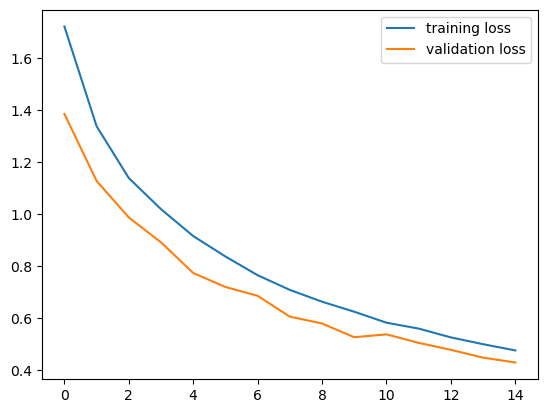

In [29]:
plt.plot(running_loss_history, label='training loss')
plt.plot(test_running_loss_history, label='validation loss')
plt.legend()

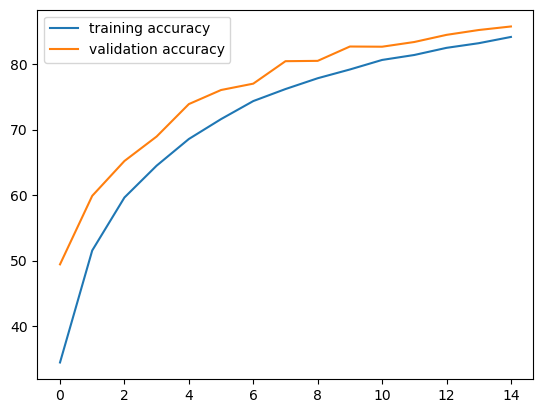

In [30]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(test_running_corrects_history, label='validation accuracy')
plt.legend()

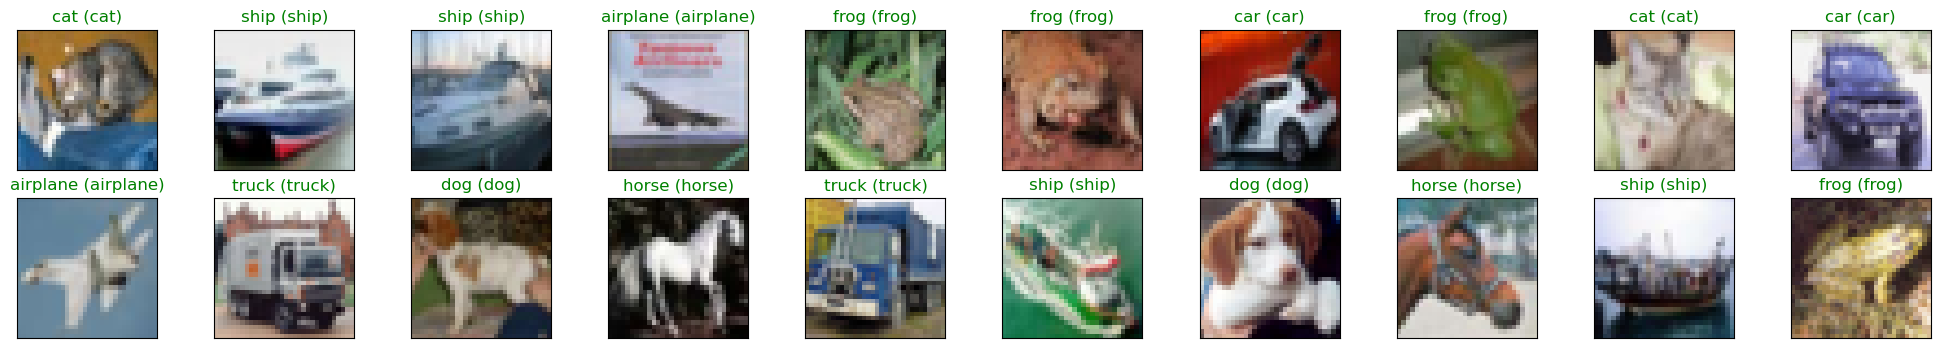

In [31]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if classes[preds[idx]]==classes[labels[idx]] else "red"))